**Clone git repository to access to dataset and resouces**

In [1]:
!git clone https://github.com/nqkhanh2002/Multilabel-Sentiment-Analysis.git

Cloning into 'Multilabel-Sentiment-Analysis'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 27 (delta 3), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (27/27), done.


# Pipeline Project

# Dowload Dataset
Dataset: Mutilple Sentiment Analysis ([SemEval 2018 Task 1](https://alt.qcri.org/semeval2018/index.php?id=tasks))

https://huggingface.co/datasets/sem_eval_2018_task_1

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 32.9 MB/s 
     |████████████████████████████████| 182 kB 74.3 MB/s 
     |████████████████████████████████| 213 kB 78.9 MB/s 
     |████████████████████████████████| 132 kB 77.6 MB/s 
     |████████████████████████████████| 127 kB 72.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
from datasets import load_dataset

dataset = load_dataset("sem_eval_2018_task_1", 'subtask5.english')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6838 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3259 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/886 [00:00<?, ? examples/s]

Dataset sem_eval_2018_task_1 downloaded and prepared to /root/.cache/huggingface/datasets/sem_eval_2018_task_1/subtask5.english/1.1.0/a7c0de8b805f1988b118882fb289ccfbbeb9085c7820b6f046b5887e234af182. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# dataset['train'].to_csv('Dataset/train.csv')

In [5]:
# dataset['test'].to_csv('Dataset/test.csv')

In [6]:
# dataset['validation'].to_csv('Dataset/valid.csv')

# Prepare Dataset

In [7]:
import os
import pandas as pd
ROOT_FOLDER_PATH = '/content/Multilabel-Sentiment-Analysis/Dataset'
train_filepath = os.path.join(ROOT_FOLDER_PATH, 'train.csv')
val_filepath = os.path.join(ROOT_FOLDER_PATH, 'valid.csv')
test_filepath = os.path.join(ROOT_FOLDER_PATH, 'test.csv')

train_df = pd.read_csv(train_filepath, index_col=0)
val_df = pd.read_csv(val_filepath, index_col=0)
test_df = pd.read_csv(test_filepath, index_col=0)


In [8]:
import numpy as np
# Find all classname
class_lst = np.array(train_df.columns[2:])
print(class_lst)
n_classes = len(class_lst)
print(f'Number of classes: {n_classes}')
# Find number of saples
n_samples = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
n_samples

['anger' 'anticipation' 'disgust' 'fear' 'joy' 'love' 'optimism'
 'pessimism' 'sadness' 'surprise' 'trust']
Number of classes: 11


10983

# Normalization 

In [9]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 26.6 MB/s 


In [10]:
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

english_stopwords = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalization(text):
    # Convert to lower case
    text = text.lower()
    # Convert to ASCII
    text = unidecode.unidecode(text)
    text = text.strip()
    # Remove any special characters and white spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stopwords])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: text_normalization(x)).astype(str)
val_df['Tweet'] = val_df['Tweet'].apply(lambda x: text_normalization(x)).astype(str)
test_df['Tweet'] = test_df['Tweet'].apply(lambda x: text_normalization(x)).astype(str)

In [12]:
train_df['Tweet']

0      worri payment problem may never  joyc meyer  m...
1                      whatev decid make sure make happi
2      max_kellerman  also help major nfl coach inept...
3      accept challeng liter even feel exhilar victor...
4      roommat okay cant spell autocorrect terribl fi...
                             ...                        
833    nicky57672 hi work toward highlight concern ke...
834    andreamitchel said berniesand play hrc campaig...
835    isthataspid dhodg fight guy dont insult lion l...
836                     wonder guy broke peni sex seriou
837               im highli anim even though im decompos
Name: Tweet, Length: 6838, dtype: object

## Split dataframe to set of tweets and set of labels (X, y)

In [13]:
X_train = train_df['Tweet'].to_numpy()
y_train = train_df[class_lst].astype('int').to_numpy()
X_val = val_df['Tweet'].to_numpy()
y_val = val_df[class_lst].astype('int').to_numpy()
X_test = test_df['Tweet'].to_numpy()
y_test = test_df[class_lst].astype('int').to_numpy()

In [14]:
type(X_train)

numpy.ndarray

## Convert to tf.data.Dataset

In [39]:
import tensorflow as tf
BATCH_SIZE = 128
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

## Buidling Model

In [16]:
# Define text vectorization layer
MAX_SEQ_LEN = 128
MAX_FEATURES = 5000
EMBEDDING_DIM = 64
text_vectorization_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN
)
train_text = train_ds.map(lambda text, labels: text)
text_vectorization_layer.adapt(train_text)

**Define model architecture**

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# define model sequential
model = tf.keras.Sequential([
    #input layer is string vector with shape (1,)
    layers.InputLayer(input_shape=(1,), dtype=tf.string),
    # text vectorization layer
    text_vectorization_layer,
    #Embedding layer
    layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),
    # Bidirectional LSTM layer 1 return vector ouput of time step to input to next layer bidirectional
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Bidirectional LSTM layer 2 return hidden state of last time step
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    # Bidirectional LSTM layer 3 return vector ouput of time step
    layers.Bidirectional(layers.LSTM(64)),
    # Dropout layer 1 with 0.2 rate
    layers.Dropout(0.2),
    # Full connected layer 1 with 64 units with relu activation
    layers.Dense(64, activation='relu'),
    # Dropout layer 2 with 0.3 rate
    layers.Dropout(0.3),
    # Full connected layer 2 with 32 units with relu activation
    layers.Dense(32, activation='relu'),
    # Last layer with n_classes units with sigmoid activation
    layers.Dense(n_classes, activation='softmax')
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 128, 64)           320000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 128, 128)         66048     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 128, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                 

In [41]:
# Compile model
from keras.callbacks import ModelCheckpoint
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)
# define the checkpoint
filepath = "model.tf"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# model fit for train_ds and val_ds
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks_list
)   

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 15.8910 - accuracy: 0.1657
Epoch 1: loss improved from inf to 15.89095, saving model to model.tf


54/54 [==============================] - 47s 732ms/step - loss: 15.8910 - accuracy: 0.1657 - val_loss: 12.4241 - val_accuracy: 0.0677
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 17.0936 - accuracy: 0.1603
Epoch 2: loss did not improve from 15.89095
54/54 [==============================] - 3s 48ms/step - loss: 17.0936 - accuracy: 0.1603 - val_loss: 13.1272 - val_accuracy: 0.0677
Epoch 3/10
53/54 [============================>.] - ETA: 0s - loss: 18.6366 - accuracy: 0.1592
Epoch 3: loss did not improve from 15.89095
54/54 [==============================] - 3s 49ms/step - loss: 18.6388 - accuracy: 0.1593 - val_loss: 14.0122 - val_accuracy: 0.0677
Epoch 4/10
53/54 [============================>.] - ETA: 0s - loss: 20.5245 - accuracy: 0.1585
Epoch 4: loss did not improve from 15.89095
54/54 [==============================] - 3s 47ms/step - loss: 20.5264 - accuracy: 0.1581 - val_loss: 15.2656 - val_accuracy: 0.0147
Epoch 5/10
53/54 [============================>.] - E

In [38]:
threshold = 0.5
 # create inverse_label function with class_lst and threshold_pred as input
def inverse_label(class_lst, label):
    return ', '.join([class_lst[i] for i in range(len(class_lst)) if label[i] == 1])
for text_batch, label_batch in test_ds.take(1):
    for i in range(5):
        input_text = text_batch[i].numpy()
        label = label_batch[i].numpy()
        pred = model.predict(np.expand_dims(input_text, axis=0), verbose=1)[0]
        thresholded_pred = np.where(pred > threshold, 1, 0)
        print(f'Input text: {input_text}')    
        print(f'Label: {inverse_label(class_lst, label)}')
        print(f'Predicted label(s): ({inverse_label(class_lst, thresholded_pred)})')
        print(" ")

1/1 [==============================] - 5s 5s/step
Input text: b'adnan__786__ asyounotwish dont worri indian armi way dispatch terrorist hell'
Label: anger, anticipation, optimism, trust
Predicted label(s): (anger, anticipation, fear, sadness)
 
1/1 [==============================] - 0s 45ms/step
Input text: b'academi scienc eschew normal sober tone scientif paper call massiv loss wildlif biolog annihil'
Label: disgust
Predicted label(s): (anger, anticipation, fear, sadness)
 
1/1 [==============================] - 0s 43ms/step
Input text: b'blew opportun __ mad'
Label: anger, disgust, sadness
Predicted label(s): (anger, anticipation, fear, sadness)
 
1/1 [==============================] - 0s 42ms/step
Input text: b'time 2 week 30'
Label: joy, sadness
Predicted label(s): (anger, anticipation, fear, sadness)
 
1/1 [==============================] - 0s 43ms/step
Input text: b'deppress real partner w depress peopl truli dont understand depth affect us add anxieti ampmak wors'
Label: fear, 

## Visualize results of model


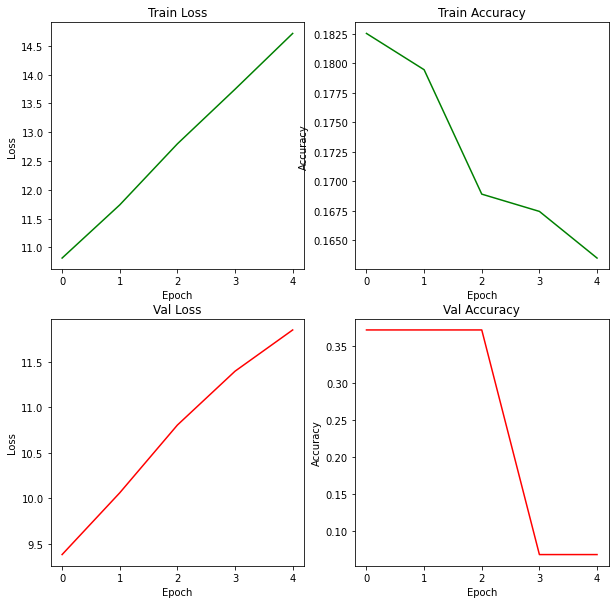

In [40]:
import matplotlib.pyplot as plt
train_loss, train_accuracy = history.history['loss'], history.history['accuracy']
val_loss, val_accuracy = history.history['val_loss'], history.history['val_accuracy']
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.plot(train_loss, color='green')

plt.subplot(2, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.plot(train_accuracy, color='green')

plt.subplot(2, 2, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val Loss')
plt.plot(val_loss, color='red')

plt.subplot(2, 2, 4)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Val Accuracy')
plt.plot(val_accuracy, color='red')

plt.show()